#Multi-Head CNN Fusion Model with TWristAR
Uses all accel and bvp with Group 3-fold (hold-one-out) validation on [TWristAR](https://zenodo.org/record/5911808).

This is a slightly cleaned up version of our development code supporting the Fusion of Learned Representations for Multimodal Sensor Data Classification paper which is out for review.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.




# Imports

In [2]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

# Get TWristAR IR3 X,y,sub arrays using gdrive link share

In [3]:
!gdown "1BmQ0F9Yws71FNGa7PH7NmHPt4guPavLL&confirm=t" # TWristAR IR3 X,y,sub arrays
t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
unpack_archive('TWristAR_IR3.zip','.','zip')

Downloading...
From: https://drive.google.com/uc?id=1BmQ0F9Yws71FNGa7PH7NmHPt4guPavLL&confirm=t
To: /content/TWristAR_IR3.zip
100% 1.81M/1.81M [00:00<00:00, 46.2MB/s]


In [4]:
# read in the arrays
X = np.load('X.npy')
y = np.load('y.npy')
sub = np.load('sub.npy')
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array    shape          data type
-------  -------------  -----------
X:       (3168, 96, 7)  float64
y:       (3168, 1)      <U10
sub:     (3168, 1)      int64


# Total Accel and BVP only, one-hot encode y.
big X is legacy from "all channels" little x indicates subset.


In [5]:
x_acc = X[:,:,0:4]
x_bvp = X[:,:,4].reshape(X.shape[0], X.shape[1], 1)

In [6]:
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
          ("x_acc:", x_acc.shape, x_acc.dtype),
          ("x_bvp:", x_bvp.shape, x_bvp.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array    shape          data type
-------  -------------  -----------
X:       (3168, 96, 7)  float64
x_acc:   (3168, 96, 4)  float64
x_bvp:   (3168, 96, 1)  float64
y:       (3168, 1)      <U10
sub:     (3168, 1)      int64


# Multi-Head Model

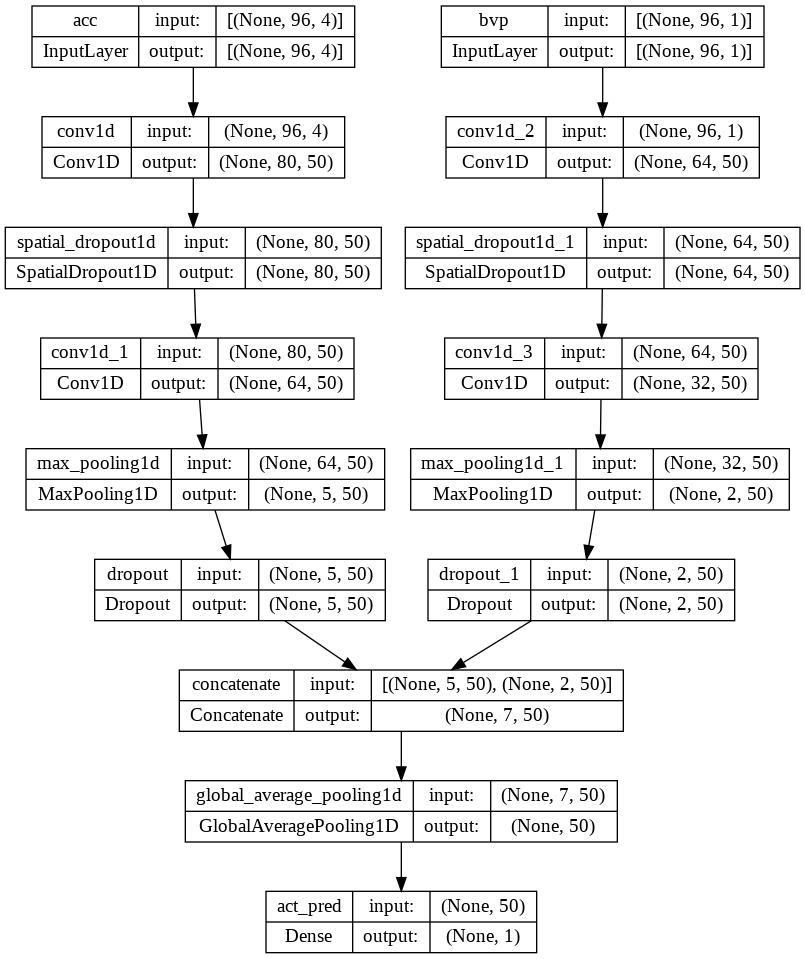

In [8]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# ref for functional model https://keras.io/guides/functional_api/
# sorry name is off, this code leveraged from a four head config
def build_4input_CNN(x_acc, x_bvp, y_train):
    n_outputs = y_train.shape[1]
    # input layers - 1st dim is timesteps, 2nd is features
    acc_input = keras.Input(shape = (x_acc.shape[1], x_acc.shape[2]), name = "acc")
    bvp_input = keras.Input(shape = (x_bvp.shape[1], x_bvp.shape[2]), name = "bvp")

    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(acc_input)
    a = layers.SpatialDropout1D(0.25)(a)
    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(a)
    a = layers.MaxPooling1D(pool_size=12)(a)
    a = layers.Dropout(0.25)(a)

    b = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(bvp_input)
    b = layers.SpatialDropout1D(0.25)(b)
    b = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(b)
    b = layers.MaxPooling1D(pool_size=12)(b)
    b = layers.Dropout(0.25)(b)

    merged = layers.Concatenate(axis=1)([a, b]) # acc and bvp only
    merged = layers.GlobalAveragePooling1D()(merged)

    # these three layers can be evaluated as alternate to GlobalAvgPool
    # merged = layers.Flatten()(merged)
    # merged = layers.Dense(100, activation='relu')(merged)
    # merged = layers.Dense(50, activation='relu')(merged)
    pred = layers.Dense(n_outputs, activation='softmax', name='act_pred')(merged)

    model = keras.Model(
        inputs=[acc_input, bvp_input],
        outputs=[pred],
    )
    return model

model = build_4input_CNN(x_acc, x_bvp, y)
# model.summary()
display(keras.utils.plot_model(model, "4input_CNN_model.png", show_shapes=True))


In [9]:
def train_4input_CNN(model, x_train_acc, x_train_bvp, y_train, 
                     x_validate_acc,x_validate_bvp, y_validate,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    NUM_EPOCHS = 100
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        {"acc": x_train_acc, "bvp": x_train_bvp},
        {"act_pred": y_train},
        #batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=({"acc": x_validate_acc, "bvp": x_validate_bvp},y_validate),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

## Run a stratified 5-fold group-based cross validation

Fold 0:
Epoch 1/100
67/67 [==============================] - 10s 14ms/step - loss: 1.6191 - accuracy: 0.5907 - val_loss: 0.7843 - val_accuracy: 0.6913
Epoch 2/100
67/67 [==============================] - 0s 7ms/step - loss: 0.5333 - accuracy: 0.8232 - val_loss: 0.6238 - val_accuracy: 0.7583
Epoch 3/100
67/67 [==============================] - 0s 7ms/step - loss: 0.3931 - accuracy: 0.8751 - val_loss: 0.5620 - val_accuracy: 0.7573
Epoch 4/100
67/67 [==============================] - 0s 7ms/step - loss: 0.3297 - accuracy: 0.9022 - val_loss: 0.4861 - val_accuracy: 0.8184
Epoch 5/100
67/67 [==============================] - 1s 8ms/step - loss: 0.2737 - accuracy: 0.9200 - val_loss: 0.6890 - val_accuracy: 0.7583
Epoch 6/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2262 - accuracy: 0.9341 - val_loss: 0.3689 - val_accuracy: 0.8592
Epoch 7/100
67/67 [==============================] - 1s 7ms/step - loss: 0.1926 - accuracy: 0.9439 - val_loss: 0.3736 - val_accuracy: 0.8563
Epo

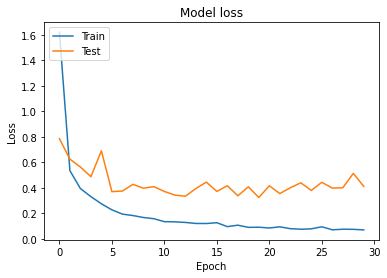

Fold 1:
Epoch 1/100
65/65 [==============================] - 2s 15ms/step - loss: 1.7369 - accuracy: 0.6273 - val_loss: 1.2676 - val_accuracy: 0.4812
Epoch 2/100
65/65 [==============================] - 0s 8ms/step - loss: 0.5397 - accuracy: 0.8055 - val_loss: 0.9506 - val_accuracy: 0.7049
Epoch 3/100
65/65 [==============================] - 0s 7ms/step - loss: 0.3590 - accuracy: 0.8897 - val_loss: 1.0624 - val_accuracy: 0.6774
Epoch 4/100
65/65 [==============================] - 0s 6ms/step - loss: 0.2941 - accuracy: 0.9090 - val_loss: 0.8780 - val_accuracy: 0.7049
Epoch 5/100
65/65 [==============================] - 0s 7ms/step - loss: 0.2452 - accuracy: 0.9283 - val_loss: 0.8939 - val_accuracy: 0.7553
Epoch 6/100
65/65 [==============================] - 0s 7ms/step - loss: 0.2089 - accuracy: 0.9403 - val_loss: 0.9813 - val_accuracy: 0.7479
Epoch 7/100
65/65 [==============================] - 0s 7ms/step - loss: 0.1815 - accuracy: 0.9533 - val_loss: 0.7926 - val_accuracy: 0.7864
Epoc

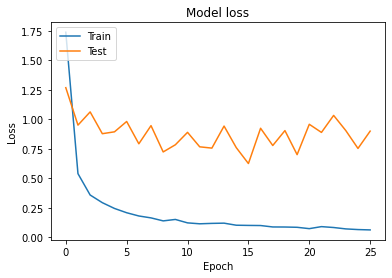

Fold 2:
Epoch 1/100
67/67 [==============================] - 2s 14ms/step - loss: 2.1360 - accuracy: 0.5549 - val_loss: 0.9706 - val_accuracy: 0.5692
Epoch 2/100
67/67 [==============================] - 1s 8ms/step - loss: 0.5468 - accuracy: 0.7982 - val_loss: 0.7308 - val_accuracy: 0.6896
Epoch 3/100
67/67 [==============================] - 0s 7ms/step - loss: 0.4045 - accuracy: 0.8637 - val_loss: 0.5619 - val_accuracy: 0.7574
Epoch 4/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2972 - accuracy: 0.8996 - val_loss: 0.6096 - val_accuracy: 0.7603
Epoch 5/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2435 - accuracy: 0.9203 - val_loss: 0.5798 - val_accuracy: 0.7880
Epoch 6/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2238 - accuracy: 0.9231 - val_loss: 0.7435 - val_accuracy: 0.7851
Epoch 7/100
67/67 [==============================] - 1s 14ms/step - loss: 0.1977 - accuracy: 0.9415 - val_loss: 0.5285 - val_accuracy: 0.7908
Epo

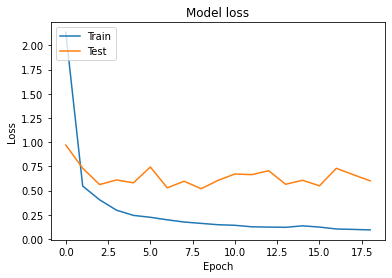

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.4098140299320221 - Accuracy: 87.76699304580688%
> Fold 1 - Accuracy: 87.76699304580688%
> Fold 2 - Loss: 0.8997557163238525 - Accuracy: 74.51878786087036%
> Fold 2 - Accuracy: 74.51878786087036%
> Fold 3 - Loss: 0.6007091403007507 - Accuracy: 80.133718252182%
> Fold 3 - Accuracy: 80.133718252182%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 80.80649971961975 (+- 5.429438972413295)
------------------------------------------------------------------------


In [10]:
# original source NNCLR_Multi_CNN_Funct_classifier_TWristAR_and_UE4W_4.ipynb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder

import sys

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_test_per_fold = []

skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X, y, groups=sub)):
    print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")
    # print(f"  Groups:   index={sub_labeled[test_index]}")


    x_train_acc, x_train_bvp = x_acc[train_index], x_bvp[train_index]
    x_test_acc, x_test_bvp = x_acc[test_index], x_bvp[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # le = LabelEncoder()
    enc = OneHotEncoder(categories='auto', sparse=False)
    y_train = enc.fit_transform(y_train)
    y_test = enc.fit_transform(y_test)

    # Generate generalization metrics
    # scores = finetuning_model_cv.evaluate([x_test_acc, x_test_bvp, x_test_eda, x_test_temp], y_test, verbose=0)
    # scores = finetuning_model_cv.evaluate([x_test_acc, x_test_bvp], y_test, verbose=0)
    model = build_4input_CNN(x_train_acc, x_train_bvp, y_train)
    history, model = train_4input_CNN(model, x_train_acc, x_train_bvp, y_train,
                                          x_test_acc,x_test_bvp, y_test)  
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1] 
    # print(f"  Test loss: {scores[0]}")
    # print(f"  Test accuracy: {scores[1]}")
    # acc_per_fold.append(scores[1] * 100)
    acc_per_fold.append(val_acc * 100)
    #loss_per_fold.append(scores[0])
    loss_per_fold.append(val_loss)

    # Generate predictions
    # y_pred = finetuning_model_cv.predict([x_test_acc, x_test_bvp, x_test_eda, x_test_temp])
    # y_pred = finetuning_model_cv.predict([x_test_acc, x_test_bvp])
    y_pred = model.predict({"acc": x_test_acc, "bvp": x_test_bvp}, verbose = 0)

    y_pred = np.argmax(y_pred, axis=1)
    y_pred_per_fold.append(y_pred)
    y_test_per_fold.append(np.argmax(y_test, axis=1))

    # Plot training & validation accuracy values
    # plt.plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Confusion matrix, without normalization
[[442   0   3   8  15  22]
 [  2 460   0   0   5  53]
 [  4   2 373   8   3 134]
 [  6   1   7 487  15  12]
 [ 21   9   0   8 462  68]
 [ 11  12   4   0 179 332]]


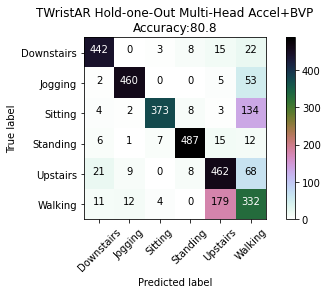

In [11]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

y_pred = np.concatenate(y_pred_per_fold)
y_test = np.concatenate(y_test_per_fold)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'TWristAR Hold-one-Out Multi-Head Accel+BVP\n'
title += 'Accuracy:{0:.1f}'.format(np.mean(acc_per_fold))
plot_confusion_matrix(cm, classes=t_names, title=title, cmap='cubehelix_r')